# 프로젝트: 한영 번역기 만들기

===========================================================================================

## 목차

>### 1. 데이터 불러오기
>### 2. 데이터 전처리
>### 3. 모델 구성하기
>### 4. 모델 학습 및 결과 확인
>### 5. 회고
>### 6. Reference
>### 7. 자기다짐 및 아쉬운 점

---

## 루브릭 달성 조건

1. 번역기 모델 학습에 필요한 텍스트 데이터 전처리가 한국어 포함하여 잘 이루어졌다.
    - 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.
2. Attentional Seq2seq 모델이 정상적으로 구동된다.
    - seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.
3. 테스트 결과 의미가 통하는 수준의 번역문이 생성되었다.
    - 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.

---

## 1. 데이터 불러오기

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from tqdm import tqdm

from konlpy.tag import Mecab
from bs4 import BeautifulSoup 
import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.layers import GRU, Dropout, Dense, Embedding, BatchNormalization, LayerNormalization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [2]:
%config InlineBackend.figure_format = 'retina'

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

In [3]:
ko_path = './data/korean-english-park.train.ko'
eng_path = './data/korean-english-park.train.en'

In [4]:
kor_corpus = []
eng_corpus = []

count = 0
with open(ko_path, 'r') as k:
    while True:
        sentence = k.readline()        
        kor_corpus.append(sentence)
        count += 1
        if count == 50000:
            break
            
count = 0            
with open(eng_path, 'r') as e:
    while True:
        sentence = e.readline()             
        eng_corpus.append(sentence)
        count += 1
        if count == 50000:
            break          

- 데이터의 노이즈가 많아 약 9만5천개의 데이터 중 전반적으로 노이즈가 적은 5만개만 사용

---
## 2. 데이터 전처리

In [5]:
kor_df = pd.DataFrame(kor_corpus)
eng_df = pd.DataFrame(eng_corpus)

kor_df.rename(columns = {0:'kor_corpus'}, inplace=True)
eng_df.rename(columns = {0:'eng_corpus'}, inplace=True)

df = pd.concat([kor_df, eng_df], axis=1)

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.isna().sum()

kor_corpus    0
eng_corpus    0
dtype: int64

In [8]:
df.reset_index(inplace=True, drop=True)

In [9]:
def clear_sentence(sentence, s_token=False, e_token=False): # 전처리 함수
    sentence = BeautifulSoup(sentence, "lxml").text
    sentence = re.sub(r'\([^)]*\)', r'', sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[^a-zA-Z가-힣 ]+', r'', sentence)
    sentence = re.sub(r"['\n']+", r"", sentence)
    sentence = re.sub(r'["   "]+', " ", sentence)
    
    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

In [10]:
def tokenize(corpus, kor=False, num_words = 15000): # 토크나이저 함수
    if kor:
        mecab = Mecab()
        sentences = []
        for sentence in tqdm(corpus):
            sentences.append(mecab.morphs(sentence))
        corpus = sentences
            
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=num_words, filters=" ", char_level=False)
    
    tokenizer.fit_on_texts(corpus)
    
    tensor = tokenizer.texts_to_sequences(corpus)
        
    return tensor, tokenizer

In [11]:
def max_min_len(data, name): # 길이 분포 확인 함수
    max_len = 0
    min_len = 999
    total_len = 0

    for i in tqdm(range(len(data))):
        if len(data[i]) < min_len:
            min_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) > max_len:
            max_len = len(data[i])
            total_len += len(data[i])
        elif len(data[i]) >= min_len or len(data[i]) <= max_len:
            total_len += len(data[i])
    mean_len = total_len//len(data)
    
    print(f'{name} 데이터셋의 최대 길이: {max_len}')
    print(f'{name} 데이터셋의 최소 길이: {min_len}')
    print(f'{name} 데이터셋의 평균 길이: {mean_len}')
    print(f'{name} 데이터셋의 총 길이: {total_len}')
    print('----'*32)
    
    sentence_length = np.zeros((max_len), dtype=np.int)

    for s in data:
        sentence_length[len(s)-1] += 1

    plt.bar(range(max_len), sentence_length, width=1.0)
    plt.title("{} Length".format(name))
    plt.show()
    
max_num = 40
min_num = 15

In [12]:
def length_sentence(corpus, min_num = 0, max_num = 25000, name=None): # 길이 조절 함수
    corpus_len = len(corpus)
    for i in tqdm(range(corpus_len)):
        if len(corpus[i]) <= min_num or len(corpus[i]) > max_num:
            corpus[i] = np.nan
        else:
            corpus[i] = corpus[i]
    
    return corpus

In [13]:
for idx, sentence in enumerate(tqdm(df['kor_corpus'])):
    sentence = clear_sentence(sentence)
    df['kor_corpus'][idx] = sentence
    
for idx, sentence in enumerate(tqdm(df['eng_corpus'])):
    sentence = clear_sentence(sentence, s_token=True, e_token=True)
    df['eng_corpus'][idx] = sentence    

100%|██████████| 49639/49639 [00:29<00:00, 1682.80it/s]


In [14]:
df.head()

,kor_corpus,eng_corpus
0,개인용 컴퓨터 사용의 상당 부분은 이것보다 뛰어날 수 있느냐,<start> Much of personal computing is about ca...
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,<start> so a mention a few weeks ago about a r...
2,그러나 이것은 또한 책상도 필요로 하지 않는다,<start> Like all optical mice But it also does...
3,달러하는 이 최첨단 무선 광마우스는 허공에서 팔목 팔 그외에 어떤 부분이든 그 움...,<start> uses gyroscopic sensors to control the...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 계획들이 실패로 돌아갔음을 밝혔...,<start> Intelligence officials have revealed a...


In [15]:
df['kor_corpus'], kor_tokenizer = tokenize(df['kor_corpus'], kor=True, num_words = 15000)
df['eng_corpus'], eng_tokenizer = tokenize(df['eng_corpus'], kor=False, num_words = 15000)

100%|██████████| 49639/49639 [00:07<00:00, 6938.18it/s]


100%|██████████| 49639/49639 [00:00<00:00, 108690.42it/s]


한국어 데이터셋의 최대 길이: 119
한국어 데이터셋의 최소 길이: 0
한국어 데이터셋의 평균 길이: 27
한국어 데이터셋의 총 길이: 1341678
--------------------------------------------------------------------------------------------------------------------------------


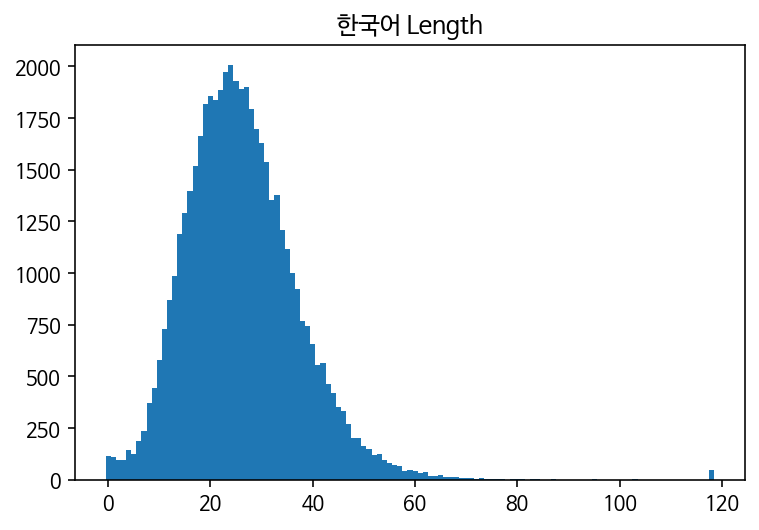

100%|██████████| 49639/49639 [00:00<00:00, 105161.29it/s]


영어 데이터셋의 최대 길이: 78
영어 데이터셋의 최소 길이: 2
영어 데이터셋의 평균 길이: 23
영어 데이터셋의 총 길이: 1166177
--------------------------------------------------------------------------------------------------------------------------------


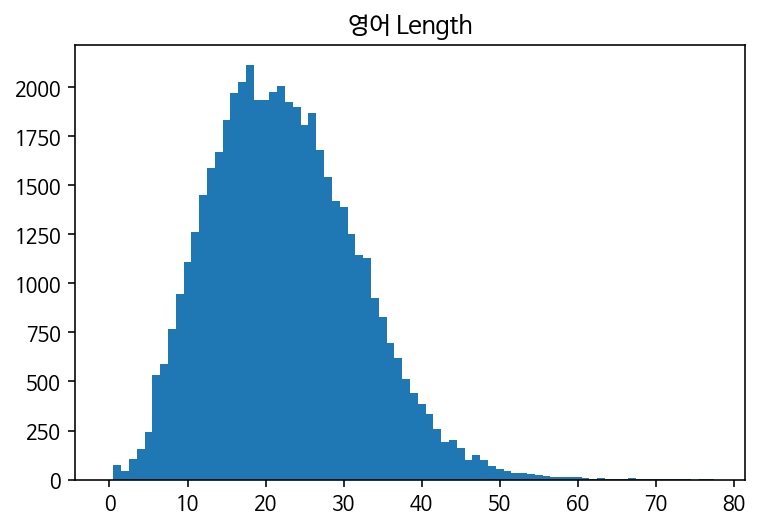

In [16]:
max_min_len(df['kor_corpus'], name='한국어')
max_min_len(df['eng_corpus'], name='영어')

In [17]:
df['kor_corpus'] = length_sentence(df['kor_corpus'], min_num = min_num, max_num = max_num, name='한국어') # max_num = 45, min_num = 15
df['eng_corpus'] = length_sentence(df['eng_corpus'], min_num = min_num, max_num = max_num, name='영어')

100%|██████████| 49639/49639 [00:13<00:00, 3727.54it/s]


In [18]:
df.isna().sum()

kor_corpus    11543
eng_corpus    12792
dtype: int64

In [19]:
df.dropna(inplace=True)

In [20]:
len(df)

31424

In [21]:
df.head()

,kor_corpus,eng_corpus
1,"[188, 5897, 5656, 25, 2405, 20, 2, 5897, 5656,...","[2, 115, 6, 3801, 6, 314, 258, 235, 40, 6, 137..."
3,"[92, 10, 3, 2, 8023, 2441, 5897, 5656, 3, 14, ...","[2, 2411, 8567, 4, 427, 1, 935, 17, 86, 443, 2..."
9,"[11, 2, 356, 2206, 2480, 2573, 996, 1162, 78, ...","[2, 857, 29, 341, 8041, 1900, 4, 323, 5435, 7,..."
11,"[7128, 1054, 3, 63, 7, 1103, 104, 7, 1706, 366...","[2, 1, 1379, 5, 2412, 14, 175, 5, 1, 134, 1806..."
12,"[584, 14, 5, 9206, 16, 2096, 4747, 7, 159, 5, ...","[2, 2413, 4, 7171, 861, 7, 912, 7585, 1, 736, ..."


In [22]:
kor_corpus = list(df['kor_corpus'])
eng_corpus = list(df['eng_corpus'])

kor_corpus = tf.keras.preprocessing.sequence.pad_sequences(kor_corpus, padding='post', maxlen=max_num) # max_num = 45
eng_corpus = tf.keras.preprocessing.sequence.pad_sequences(eng_corpus, padding='post', maxlen=max_num)

---
## 3. 모델 구성하기

In [23]:
# 하이퍼 파라미터

vocab_size = 15000
embedding_dim = 64
units = 128
BATCH_SIZE = 16
EPOCHS = 30

learning_rate = 0.0002

In [31]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

In [32]:
class Encoder(tf.keras.Model): # encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        
        self.emb = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(enc_units, return_sequences =True)
        self.batch = BatchNormalization()
        self.drop = Dropout(0.5) 
        self.norm = LayerNormalization()

    def call(self, x):
        x = self.emb(x)
        x = self.norm(x)
        x = self.gru(x)
        x = self.batch(x)      
        out = self.drop(x)

        return out

In [33]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()

        self.dec_units = dec_units

        self.emb = Embedding(vocab_size, embedding_dim)
        self.gru = GRU(dec_units, activation = 'tanh', return_sequences =True, return_state = True)
        self.batch = BatchNormalization()
        self.drop = Dropout(0.5)       
        self.dense = Dense(vocab_size)
        self.norm = LayerNormalization()
        self.attention = BahdanauAttention(self.dec_units)   # Attention 필수 사용!

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)

        x = self.emb(x)
        x = tf.concat([tf.expand_dims(context_vec, 1), x], axis=-1)
        
        x = self.norm(x)
        x, h_dec = self.gru(x)
        x = tf.reshape(x, (-1, x.shape[2]))
        x = self.batch(x)
        x = self.drop(x)

        out = self.dense(x)

        return out, h_dec, attn        

---
## 4. 모델 학습 및 결과 확인

In [34]:
encoder = Encoder(vocab_size, embedding_dim, units)
decoder = Decoder(vocab_size, embedding_dim, units)

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

In [36]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

In [37]:
for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_corpus.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(kor_corpus[idx:idx+BATCH_SIZE],
                                eng_corpus[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 30: 100%|██████████| 1964/1964 [02:41<00:00, 12.13it/s, Loss 1.4319]


In [38]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_corpus.shape[-1], kor_corpus.shape[-1]))
    
    sentence = input_sentence(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=max_num,
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_corpus.shape[-1]):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(6,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

In [39]:
def input_sentence(sentence):
    mecab = Mecab()
    x = mecab.morphs(sentence)
    
    return x

Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama is facing the largest neighborhood <end> 


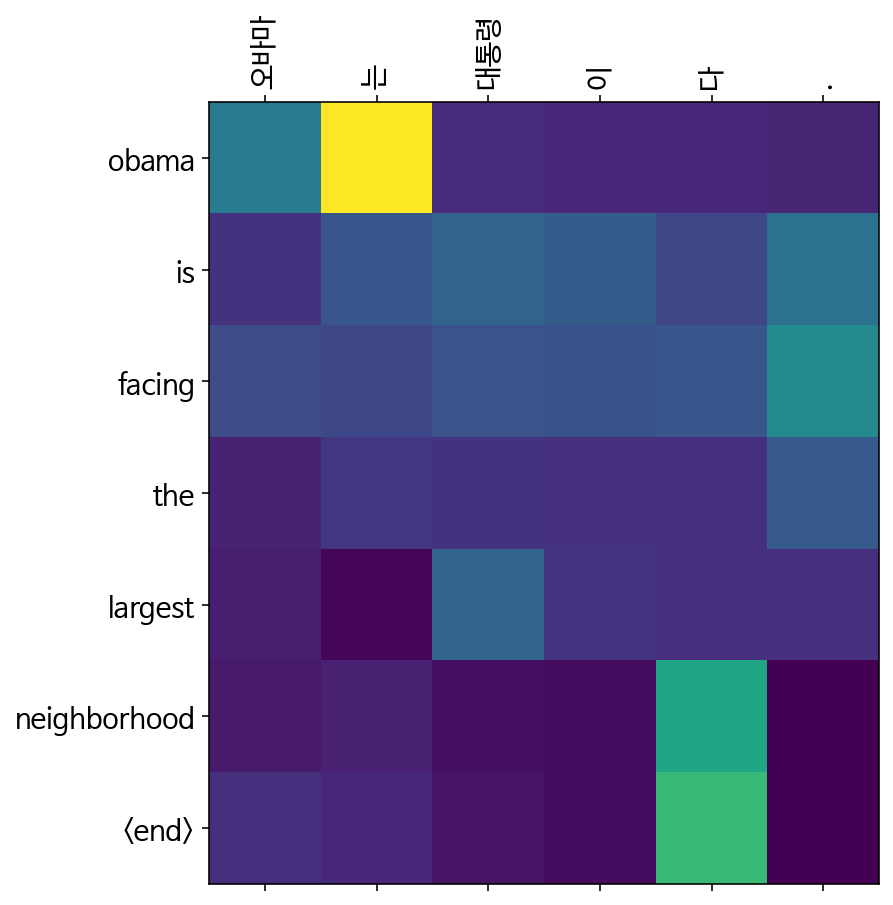

In [40]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: parents in the streets of the streets <end> 


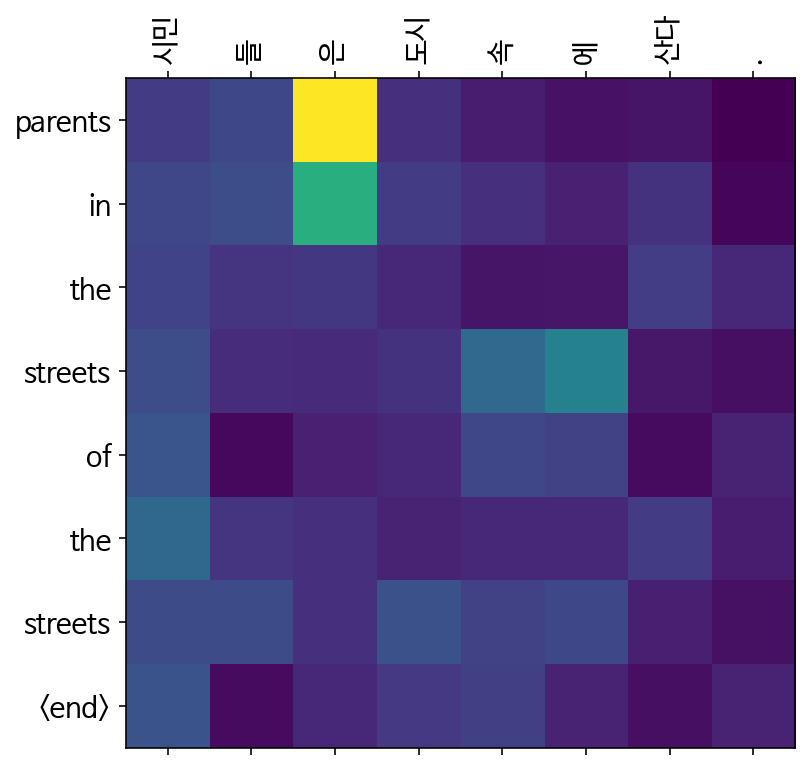

In [41]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: coffee has now dont have <end> 


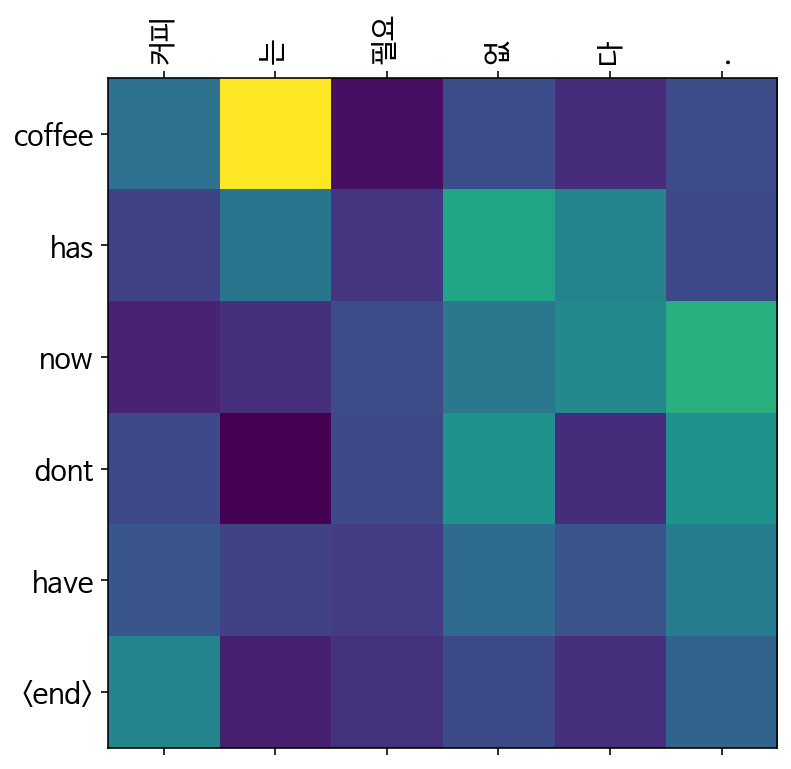

In [42]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['산불', '로', '인해', '큰', '피해', '를', '입', '었', '다', '.']
Predicted translation: wildfires have scorched more than fires <end> 


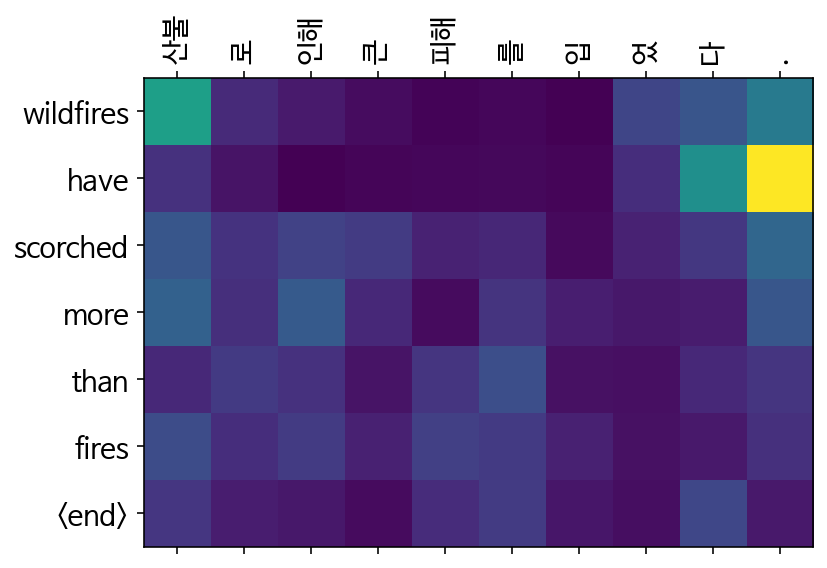

In [44]:
translate("산불로 인해 큰 피해를 입었다.", encoder, decoder)

Input: ['지구', '온도', '의', '상승', '으로', '빙하', '가', '녹', '아', '해수면', '이', '상승', '하', '였', '다', '.']
Predicted translation: glaciers that melting ice sheets of the arctic ocean <end> 


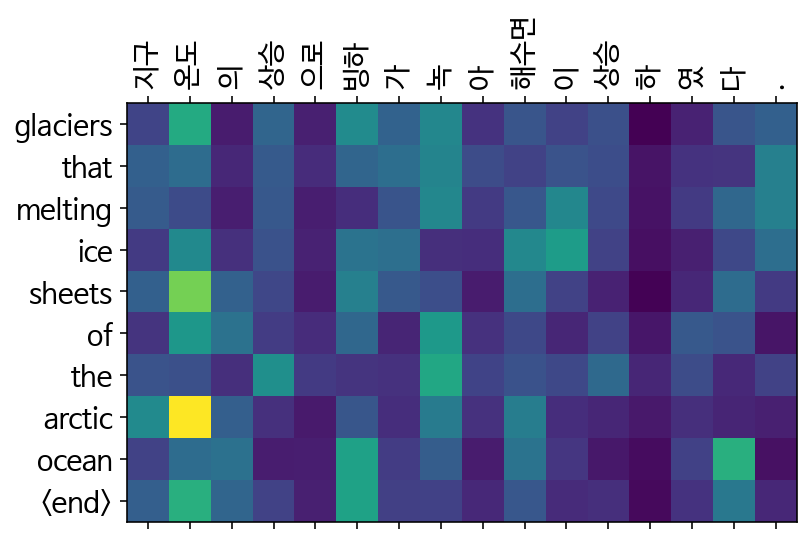

In [50]:
translate("지구온도의 상승으로 빙하가 녹아 해수면이 상승하였다.", encoder, decoder)

Input: ['광산', '이', '무너져', '광부', '8', '명', '이', '실종', '됐', '다', '.']
Predicted translation: a miners were missing by a wooden mine in the mines <end> 


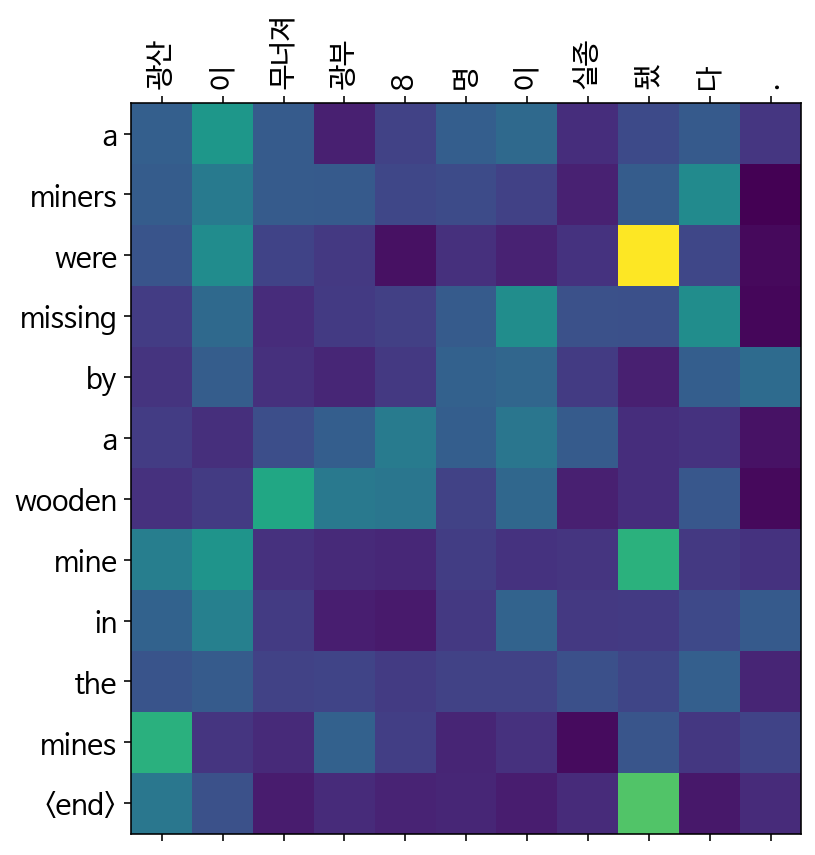

In [54]:
translate("광산이 무너져 광부 8명이 실종됐다.", encoder, decoder)

Input: ['노벨상', '수상자', '가', '발표', '되', '었', '다', '.']
Predicted translation: the nobel peace prize was also announced <end> 


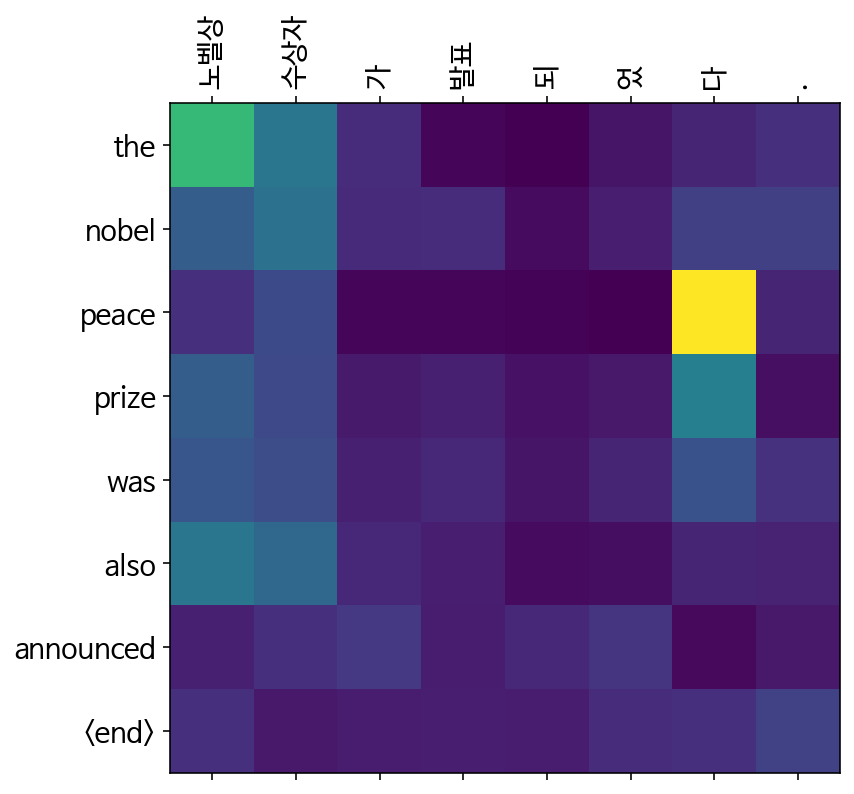

In [84]:
translate("노벨상 수상자가 발표되었다.", encoder, decoder)

Input: ['7', '살', '아이', '가', '실종', '되', '었', '다', '.']
Predicted translation: a yearold man was missing <end> 


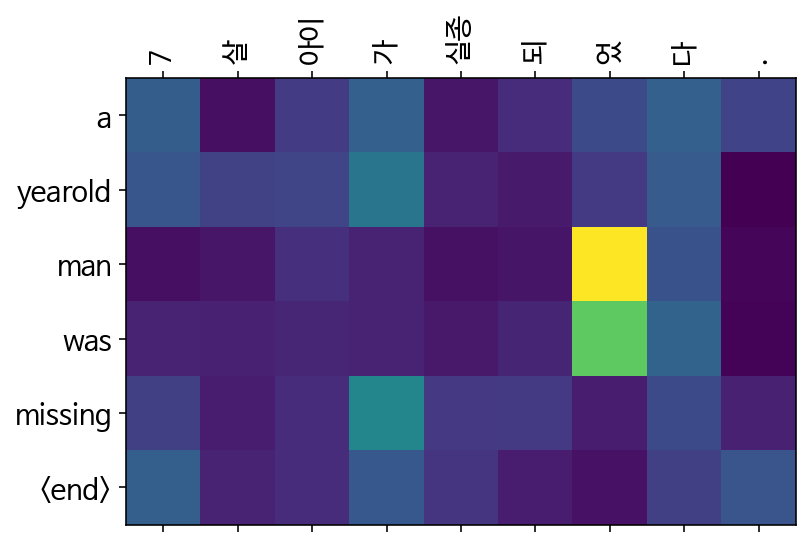

In [104]:
translate("7살 아이가 실종되었다.", encoder, decoder)

|입력문|예측문|예측문 번역|
|------|---|---|
|오바마는 대통령이다.|obama is facing the largest neighborhood|오바마는 가장 큰 동네를 마주하고 있습니다.|
|시민들은 도시 속에 산다.|parents in the streets of the streets|거리의 거리에 있는 부모|
|커피는 필요 없다.|coffee has now dont have|커피는 이제 없다|
|산불로 인해 큰 피해를 입었다.|wildfires have scorched more than fires|산불이 산불보다 더 많이 태웠다|
|지구온도의 상승으로 빙하가 녹아 해수면이 상승하였다.|glaciers that melting ice sheets of the arctic ocean|북극해의 빙상을 녹이는 빙하|
|광산이 무너져 광부 8명이 실종됐다.|a miners were missing by a wooden mine in the mines|광산의 목재 광산에서 광부가 실종되었습니다.|
|노벨상 수상자가 발표되었다.|the nobel peace prize was also announced|노벨 평화상도 발표|
|7살 아이가 실종되었다.|a yearold man was missing|한 살짜리 남자가 실종되었다|

---
## 5. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트에서 가장 어려웠던건 바다나우 어텐션의 구조 이해가 가장 어려웠습니다. 처음 보는 구조라 생각보다 머리에 잘 들어오지 않았고 레이어의 내부 구조 이해가 확 와닿지 않았습니다.

### 이번 프로젝트에서 학습한 내용
>- 이번 프로젝트에선 어텐션 구조에 대해서 많이 학습하였고 어느정도 이해가 되었습니다.

### 알아낸 점이나 모호한 점
>- 위와 동일하게 어텐션에 관해 많이 공부하고 알게되었으나 아직 확실하고 명확하지는 않습니다.

### 루브릭 평가지표를 맞추기 위해 노력했던 점
>- __1. 구두점, 대소문자, 띄어쓰기, 한글 형태소분석 등 번역기 모델에 요구되는 전처리가 정상적으로 진행되었다.__ 은 데이터 전처리 과정에서 모두 정상적으로 진행되었습니다.
>- __2. seq2seq 모델 훈련 과정에서 training loss가 안정적으로 떨어지면서 학습이 진행됨이 확인되었다.__ training loss가 train step 과정에서 우하향하는 모습을 보여주었습니다.
>- __3. 테스트용 디코더 모델이 정상적으로 만들어져서, 정답과 어느 정도 유사한 영어 번역이 진행됨을 확인하였다.__ 이 루브릭은 LMS상 한-영 번역문과는 그다지 일치하지 않았으나 제 모델의 한-영 번역문에서는 생각보다 꽤 의미있고 비슷한 단어들을 유추해 내는것을 볼 수 있었습니다.

### 루브릭 평가지표를 달성하지 못했다면 이유
>- 이번 프로젝트에서는 루브릭 평가지표에서 달성하지 못한 부분은 없었다고 생각합니다.

---
## 6. Reference

- [NEURAL MACHINE TRANSLATION
BY JOINTLY LEARNING TO ALIGN AND TRANSLATE 논문](https://arxiv.org/pdf/1409.0473.pdf)
- [Attention is All you need 논문](https://ar5iv.labs.arxiv.org/html/1706.03762)

---
## 7. 자기다짐 및 아쉬운 점

- 이번 프로젝트는 꽤 재밌었고 좋았습니다. Exploration때 했던 번역문보다 훨씬 좋은 성능을 보여주었고 신경망에 대한 이해가 상당히 커져서 좋았습니다.
    
    
- 다만, 아쉬운 점으로는 어텐션에 대한 이해가 조금 부족한듯 하고 히트맵을 보았을때 어텐션 스코어들이 일치하지 않는 모습을 보여주는게 조금 아쉬웠습니다.